## Importing necessary libraries

In [ ]:
import tensorflow as tf
import sklearn
import numpy as np
import re, os

## Loading CIFAR-10 Dataset

In [ ]:
(X_train,Y_train),(X_test,Y_test)=tf.keras.datasets.cifar10.load_data()

## Preprocessing and Sampling

In [ ]:
X_train = X_train/255
X_test = X_test/255
Y_train = Y_train
Y_test = tf.keras.utils.to_categorical(Y_test,10)

X_train.shape,Y_train.shape

((50000, 32, 32, 3), (50000, 1))

In [ ]:
X_train,Y_train = sklearn.utils.shuffle(X_train,Y_train)

train_features,train_labels = X_train[:30000], tf.keras.utils.to_categorical(Y_train[:30000],10)
oracle_features1, oracle_labels1 = X_train[30000:40000], tf.keras.utils.to_categorical(Y_train[30000:40000],10)
oracle_features2, oracle_labels2 = X_train[40000:45000], tf.keras.utils.to_categorical(Y_train[40000:45000],10)
val_features, val_labels = X_train[45000:50000], tf.keras.utils.to_categorical(Y_train[45000:50000],10)

## Creating the Model

In [ ]:
from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization, Dropout
def create_model():
  model = tf.keras.models.Sequential()
  model.add(Conv2D(256,(2,2),input_shape=(32,32,3),kernel_initializer='he_uniform'))
  model.add(MaxPooling2D())
  model.add(Conv2D(128,(2,2),kernel_initializer='he_uniform'))
  model.add(MaxPooling2D())
  model.add(Conv2D(64,(2,2),kernel_initializer='he_uniform'))
  model.add(MaxPooling2D())
  model.add(Conv2D(32,(1,1),kernel_initializer='he_uniform'))
  model.add(MaxPooling2D())
  model.add(Flatten())
  model.add(Dense(256,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(128,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dropout(0.2))
  model.add(Dense(32,activation='relu',kernel_initializer='he_uniform'))
  model.add(Dense(10,activation='softmax',kernel_initializer='he_uniform'))
  model.summary()
  model.compile(optimizer=tf.keras.optimizers.Adam(0.0005),loss='categorical_crossentropy',metrics=['accuracy'])
  return model

## Active Learning Based Training

In [ ]:
histories = []
model = create_model()
history = model.fit(train_features,train_labels,validation_data=(val_features,val_labels),epochs=35,batch_size=256,callbacks=[tf.keras.callbacks.ModelCheckpoint('Checkpoint.h5',verbose=1,save_best_only=True)])
model.evaluate(X_test,Y_test)
histories.append(history)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 31, 31, 256)       3328      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       131200    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 6, 64)          32832     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 32)          2

In [ ]:
model = tf.keras.models.load_model('Checkpoint.h5')

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('Checkpoint1.h5',verbose=1,save_best_only=True)

for iter_n, i in enumerate([(oracle_features1,oracle_labels1),(oracle_features2,oracle_labels2)]):
  predictions = model.predict(i[0])

  # Getting inconfident and wrong predictions
  inconfident_preds = np.asarray(np.abs(i[1]-predictions)>0.15).nonzero()[0]
  wrong_preds = np.not_equal(np.argmax(predictions,1),np.argmax(i[1],1)).nonzero()[0]
  
  unique = list(set(np.append(inconfident_preds,wrong_preds)))

  update_f = i[0][unique]
  update_l = i[1][unique]
  train_features = np.vstack((train_features,update_f))
  train_labels = np.vstack((train_labels,update_l))

  if iter_n != 0:
    print("Loading the best model till now")
    model = tf.keras.models.load_model('Checkpoint1.h5')
  history = model.fit(train_features,train_labels,validation_data=(val_features,val_labels),epochs=15,batch_size=256,callbacks=[checkpoint])
  histories.append(history)
  model = tf.keras.models.load_model('Checkpoint1.h5')
  print(model.evaluate(X_test,Y_test))

Epoch 1/15
151/151 [==============================] - ETA: 0s - loss: 1.2043 - accuracy: 0.5708
Epoch 00001: val_loss improved from inf to 1.31097, saving model to Checkpoint1.h5
151/151 [==============================] - 10s 64ms/step - loss: 1.2043 - accuracy: 0.5708 - val_loss: 1.3110 - val_accuracy: 0.5424
Epoch 2/15
151/151 [==============================] - ETA: 0s - loss: 1.1712 - accuracy: 0.5809
Epoch 00002: val_loss did not improve from 1.31097
151/151 [==============================] - 9s 60ms/step - loss: 1.1712 - accuracy: 0.5809 - val_loss: 1.3159 - val_accuracy: 0.5378
Epoch 3/15
151/151 [==============================] - ETA: 0s - loss: 1.1495 - accuracy: 0.5911
Epoch 00003: val_loss did not improve from 1.31097
151/151 [==============================] - 9s 61ms/step - loss: 1.1495 - accuracy: 0.5911 - val_loss: 1.3214 - val_accuracy: 0.5310
Epoch 4/15
151/151 [==============================] - ETA: 0s - loss: 1.1334 - accuracy: 0.5943
Epoch 00004: val_loss improved fro

## Training the Full Model (Just for Comparison)

In [ ]:
full_model = create_model()
full_model.fit(np.concatenate((train_features,oracle_features1,oracle_features2)),np.concatenate((train_labels,oracle_labels1,oracle_labels2)),validation_data=(val_features,val_labels),epochs=35,batch_size=256,callbacks=[tf.keras.callbacks.ModelCheckpoint('CheckpointFullModel.h5',verbose=1,save_best_only=True),tf.keras.callbacks.EarlyStopping(patience=6,verbose=1)])
full_model = tf.keras.models.load_model('CheckpointFullModel.h5')
full_model.evaluate(X_test,Y_test)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 31, 31, 256)       3328      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 15, 15, 256)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       131200    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 6, 6, 64)          32832     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 3, 32)         

[1.2284014225006104, 0.5735999941825867]

## Visualizing the results

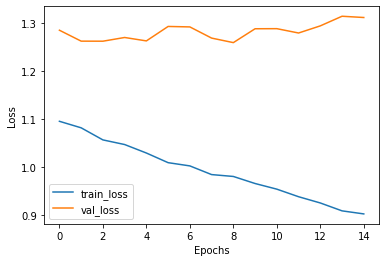

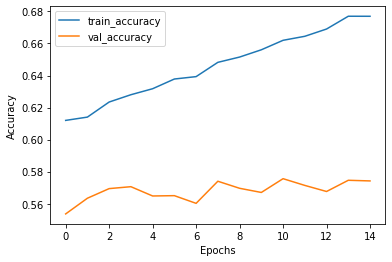

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train_loss','val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [ ]:
losses, val_losses, accuracies, val_accuracies = [], [], [], []
for h in histories:
  losses = losses + h.history['loss']
  val_losses = val_losses + h.history['val_loss']
  accuracies = accuracies + h.history['accuracy']
  val_accuracies = val_accuracies + h.history['val_accuracy']

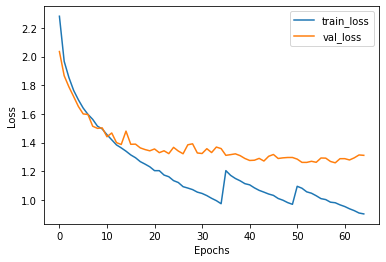

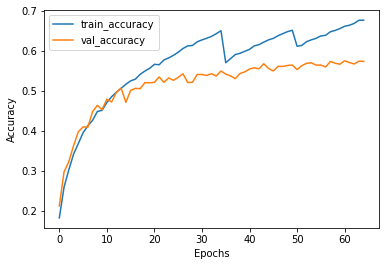

In [ ]:
plt.plot(losses)
plt.plot(val_losses)
plt.legend(['train_loss','val_loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(accuracies)
plt.plot(val_accuracies)
plt.legend(['train_accuracy','val_accuracy'])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()